<a href="https://colab.research.google.com/github/puneet-08/projects/blob/main/Naive_Bayes_and_GDA_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Naive Bayes and Gaussian Discriminant Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

sns.set_style("darkgrid")

In [2]:
# Importing Data
data = pd.read_csv("/content/Breast_cancer_data.csv")
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


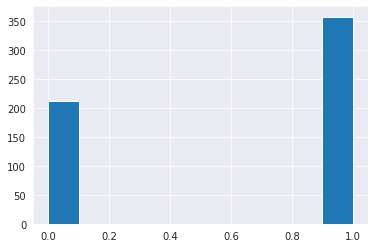

In [4]:
# Visualizing Data

data['diagnosis'].hist()

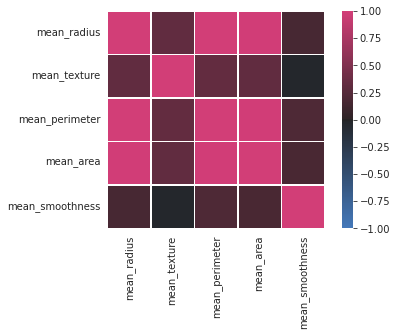

In [5]:
corr = data.iloc[:,:-1].corr(method = 'pearson')
cmap = sns.diverging_palette(250,354,75,50, center='dark', as_cmap = True)
sns.heatmap(corr, vmin=-1, vmax= 1, square=True, linewidths=0.2,cmap=cmap)

### **NAIVE BAYES**

**Approach 1: Using Continuous Data**

In [6]:
data = data[['mean_radius', 'mean_texture', 'mean_smoothness', 'diagnosis']] #dropped highly correlated features

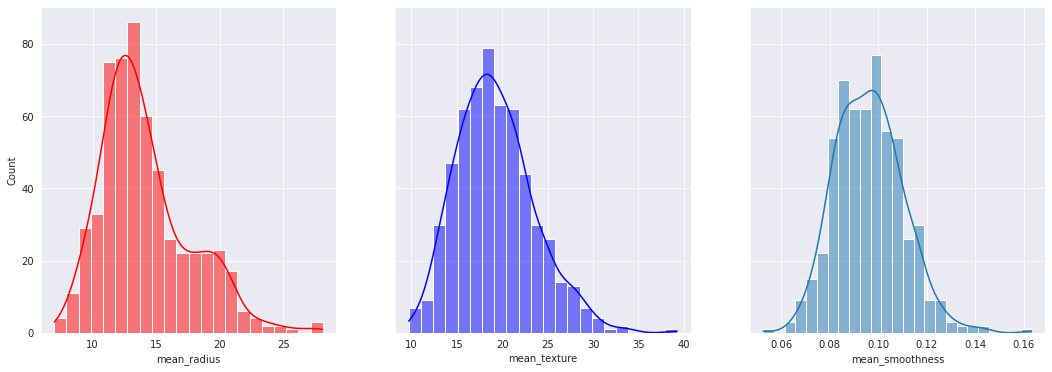

In [7]:
fig, axis = plt.subplots(1, 3, figsize = (18,6), sharey = True)

sns.histplot(data, ax = axis[0], x = 'mean_radius', kde= True, color= 'r')
sns.histplot(data, ax = axis[1], x = 'mean_texture', kde = True, color = 'b')
sns.histplot(data, ax = axis[2], x = 'mean_smoothness', kde = True)

Calculating priors i.e. P(Y=y) for all possible y




In [8]:
def prior_prob(df, Y):
  classes = sorted(list(df[Y].unique()))
  prior = []
  for i in classes:
    prior.append(len(df[df[Y]==i])/len(df))
  return prior


In [9]:
prior_prob(data, 'diagnosis')

[0.37258347978910367, 0.6274165202108963]

Calculating likelyhood i.e. P(X=x|Y=y) using gaussian distribution


In [10]:
def likelyhood_prob(df, column, Y, feat_value, label):
  mean, std = np.mean(df[df[Y]==label][column]), np.std(df[df[Y]==label][column])
  p_x_given_y = (1/(np.sqrt(2*np.pi)*std)) * (np.exp(-(((feat_value-mean)/std)**2)/2))
  return p_x_given_y

Calculating P(X=x1| Y= y)P(X=x2| Y= y).....P(X=xn| Y=y)* P(Y=y) for all Y and find maximum

In [11]:
list(data.columns)[:-1]

['mean_radius', 'mean_texture', 'mean_smoothness']

In [12]:
def naive_bayes_gaussian(df,X ,Y):

  features = list(df.columns)[:-1]

  prior = prior_prob(df, Y)

  Y_pred = []
  labels = sorted(list(df[Y].unique()))
  
  for x in X: #looping over each sample point
    likelyhood = [1]*len(labels)
    for i in range(len(labels)):
      for j in range(len(features)):
        likelyhood[i] *= likelyhood_prob(df, features[j], Y, x[j], i)

    post_prob = [1]*len(labels)
    for k in range(len(post_prob)):
      post_prob[k] = likelyhood[k]*prior[k]
    
    Y_pred.append(np.argmax(post_prob))


  return np.array(Y_pred)

In [13]:
#Training and Predicting

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


 **Approach 2: Converting continuous data to categorical data**

In [14]:
data['mean_radius_cat'] = pd.cut(data['mean_radius'].values, bins= 3, labels = [0,1,2])
data['mean_texture_cat'] = pd.cut(data['mean_texture'].values, bins = 3, labels=[0,1,2])
data['mean_smoothness_cat'] = pd.cut(data['mean_smoothness'].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=['mean_radius', "mean_texture", "mean_smoothness"])

In [15]:
data.columns

Index(['diagnosis', 'mean_radius_cat', 'mean_texture_cat',
       'mean_smoothness_cat'],
      dtype='object')

In [16]:
data = data[['mean_radius_cat', "mean_texture_cat", 'mean_smoothness_cat', 'diagnosis']]

Calculating likelyhood i.e. P(X=x|Y=y) using gaussian distribution

In [21]:
def likelyhood_prob_cat(df, column, Y, feat_value, label):
  df = df[df[Y]==label]
  prob_x_given_y = len(df[df[column]==feat_value])/len(df)
  return prob_x_given_y


Calculating P(X=x1| Y= y)P(X=x2| Y= y).....P(X=xn| Y=y)* P(Y=y) for all Y and find maximum

In [20]:
def naive_bayes_categorical(df,X,Y):
  features = list(df.columns)[:-1]
  labels = sorted(list(df[Y].unique()))

  prior = prior_prob(df,Y)
  Y_pred = []

  for x in X:
    likelyhood = [1]*len(labels)
    for i in range(len(labels)):
      for j in range(len(features)):
        likelyhood[i] *= likelyhood_prob_cat(df,features[j], Y, x[j], i)
    
    post_prob = [1]*len(labels)
    for k in range(len(labels)):
      post_prob[k] = likelyhood[k] * prior[k]

    Y_pred.append(np.argmax(post_prob))

  return np.array(Y_pred)



In [22]:
#Training and Predicting

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345


### **GDA**

In [23]:
data = pd.read_csv("/content/Breast_cancer_data.csv")
data = data[['mean_radius', 'mean_texture', 'mean_smoothness', 'diagnosis']]

In [24]:
def features_mean(df, label, Y):
  mu = []
  columns = df.columns[:-1]
  df = df[df[Y] ==label]
  for feature in columns:
    mu.append(df[feature].mean())
  return np.array(mu)

In [25]:
def sigma_(df, label, Y):
  df = df[df[Y]==label]
  return np.cov(df.iloc[:,:-1],rowvar=False)


Fitting data to multivariate gaussian distribution



In [26]:
def multivariate_gaussian_GDA(df, Y,label):
  mu = features_mean(df, label, Y)
  sigma = sigma_(df, label,Y)

  mul_gaussian = multivariate_normal(mean = mu, cov = sigma)
  return mul_gaussian


Calculating P(X=x|Y=y) using gaussian distribution and then argmax(y): P(Y=y|X=x)

In [29]:
def GDA_gaussian(df,X ,Y):
  labels = sorted(list(df[Y].unique()))

  prior = prior_prob(df,Y)
  Y_pred = []

  for x in X:
    likelyhood = [1]*len(labels)
    for i in range(len(labels)):
      likelyhood[i] = multivariate_gaussian_GDA(df, Y, i).pdf(x)

    post_prob = [1]*len(labels)
    for k in range(len(labels)):
      post_prob[k] = likelyhood[k] * prior[k]
    
    Y_pred.append(np.argmax(post_prob))

  return np.array(Y_pred)

In [30]:
#Training and Predicting

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = GDA_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[39  1]
 [ 2 72]]
0.979591836734694


## References

1. Lecture 5 https://www.youtube.com/watch?v=nt63k3bfXS0&list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU&index=5